# Aplicação de CNNs para a classificação multi-label de peças de roupa

#### Descrição

Projeto final da disciplina [EEL7513-09202|EEL7514-08235|EEL510417-41000056ME/DO (20192) - Introdução ao Aprendizado de Máquina](https://moodle.ufsc.br/course/view.php?id=110125).

#### Equipe

- Kauê Cano
- Ruan Cardoso Comelli

## Inicialização

In [0]:
user = 'ruan.comelli@lepten.ufsc.br'

In [2]:
from pathlib import Path

from google.colab import drive

drive_path = Path('/content/drive')

drive.mount(str(drive_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
if user in {'ruan.comelli@lepten.ufsc.br', 'ruancomelli@gmail.com', 'rugortal@gmail.com'}:
    project_path = (
        drive_path
        / 'My Drive'
        / 'Studies'
        / '2019.3'
        / 'EEL510417 - Tópicos Especiais em Processamento de Sinais - Introdução ao Aprendizado de Máquina'
        / 'Final Project'
        / 'Codes'
    )
datasets_path = project_path / 'datasets'
deepfashion_path = datasets_path / 'DeepFashion'
fashion550k_path = datasets_path / 'Fashion550k'

models_path = project_path / 'models'
models_path.mkdir(parents=True, exist_ok=True)
log_path = project_path / 'log'
log_path.mkdir(parents=True, exist_ok=True)
results_path = project_path / 'results'
results_path.mkdir(parents=True, exist_ok=True)
keras_results_path = results_path / 'keras'
keras_results_path.mkdir(parents=True, exist_ok=True)
pytorch_results_path = results_path / 'pytorch'
pytorch_results_path.mkdir(parents=True, exist_ok=True)

In [0]:
import sys
sys.path.append(str(project_path)) # this allows us to import modules defined locally

## Definições

### Impressão e formatação

In [0]:
def print_header(
    s: str,
    level: int = 0, 
    levels=['=', '-', '~', '*']
):
    """Standardized method for printing a section header.

    Prints the argument s underlined.
    
    Parameters
    ----------
    s      : string to be printed
    level  : index of level symbol to be used
    levels : list of level symbols to choose from
    """
    s = str(s)
    print()
    print(s)
    print(levels[level] * len(s))

### Caminhos

In [0]:
def relative_path(origin, destination):
    from os.path import relpath
    return relpath(destination, start=origin)

### Containers

In [0]:
def missing_elements(int_list): # source: adapted from <https://stackoverflow.com/questions/16974047/efficient-way-to-find-missing-elements-in-an-integer-sequence>
    int_list = sorted(int_list)
    if int_list:
        start, end = int_list[0], int_list[-1]
        full_list = set(range(start, end + 1))
        return sorted(full_list.difference(int_list))
    else:
        return set([])
    
def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

def extract_value(dicts, key, default_behaviour='value', default=None):
    if isinstance(dicts, dict):
        dicts = [dicts]
    
    for d in dicts:
        if key in d:
            return d[key]
        
    default_behaviour = default_behaviour.lower()
        
    if default_behaviour == 'value':
        return default
    elif default_behaviour == 'raise':
        raise ValueError(f'key {key} was not found in the dictionaries.')
    else:
        raise ValueError(f'default_behaviour must be either \'value\' or \'raise\'. Got \'{default_behaviour}\'.')

def extract_values(dicts, keys, default_behaviour='value', default=None):
    if isinstance(dicts, dict):
        dicts = [dicts]
    
    return {
        key: extract_value(dicts, key, default_behaviour='value', default=default)
        for key in keys
    }

### Valores *default*

In [0]:
def regularize_default(
    x, cond, default,
    many=False, many_cond=False, many_default=False,
    call_default=False
):
    from itertools import repeat

    if many:
        cond = cond if many_cond else repeat(cond)
        default = default if many_default else repeat(default)

        return (
            regularize_default(
                x_, cond_, default_,
                many=False, many_cond=False, many_default=False,
                call_default=call_default
            )
            for x_, cond_, default_ in zip(x, cond, default)
        )

    if cond(x):
        return x
    else:
        if call_default:
            return default()
        else:
            return default

### Gerenciador de modelos

In [0]:
from pathlib import Path
import json

class ModelManager:
    def __init__(
        self,
        models_path=None,
        table_path=None,
        encoding='utf-8',
        load_table=True,
        file_name_fmt='{index}.data',
        creator_method=None,
        creator_name=None,
        save_method=None,
        load_method=None
    ):
        def default_save_method(model, path):
            import pickle
            with path.open('wb') as file:
                pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

        def default_load_method(path):
            import pickle
            with path.open('rb') as file:
                return pickle.load(file)

        if models_path is None:
            models_path = Path('.') / 'models'
        self.models_path = Path(models_path).resolve()

        if table_path is None:
            table_path = (models_path / 'lookup_table.json').resolve()
        self.table_path = table_path

        self.encoding = encoding

        if load_table:
            self.load_lookup_table()
        
        self.file_name_fmt = file_name_fmt
        self.creator_method = creator_method
        self.creator_name = creator_name

        if save_method is None:
            self.save_method = default_save_method
        else:
            self.save_method = save_method

        if load_method is None:
            self.load_method = default_load_method
        else:
            self.load_method = load_method

    def initialize_lookup_table(self):
        self.table_path.parent.mkdir(parents=True, exist_ok=True)
        with self.table_path.open('w', encoding=self.encoding) as lookup_table_file:
            json.dump(dict(files={}), lookup_table_file, indent=4, ensure_ascii=False)

        return self

    def load_lookup_table(self):
        if not self.table_path.exists():
            self.initialize_lookup_table()
        with self.table_path.open('r', encoding=self.encoding) as lookup_table_file:
            try:
                self.lookup_table = json.load(lookup_table_file)
            except json.JSONDecodeError:
                self.initialize_lookup_table()
                return self.load_lookup_table()
        
        return self

    def save_lookup_table(self, table_path=None):
        if table_path is not None:
            self.table_path = table_path

        with self.table_path.open('w', encoding='utf-8') as lookup_table_file:
            json.dump(self.lookup_table, lookup_table_file, indent=4)
            
        return self

    def model_path(self, params, include=True):
        import json

        def as_json(obj):
            return json.loads( json.dumps(obj) )

        file_dict = self.lookup_table['files']
        for file_name, content in file_dict.items():
            if as_json(content) == as_json(params):
                break
        else:
            int_key_list = [int(Path(key).stem) for key in file_dict]
            missing_elems = missing_elements(int_key_list)
            if missing_elems:
                index = missing_elems[0]
            else:
                index = str(max(int_key_list, default=-1) + 1)
            file_name = self.file_name_fmt.format(index=index)

        file_path = (self.models_path / file_name).resolve().absolute()
        
        key = relative_path(self.table_path.parent, file_path)

        if include:
            file_dict[key] = params

        self.save_lookup_table()
        
        return file_path

    def delete_model(self, params):
        for file_name, content in self.lookup_table['files'].items():
            if content == params:
                break

        self.lookup_table['files'].pop(file_name)
        self.model_path(params).unlink()

    def save_model(self, model, path=None, params=None):
        if path is None:
            path = self.model_path(params)

        path.parent.mkdir(parents=True, exist_ok=True)

        self.save_method(model, path)
            
        return self

    def load_model(self, path):
        return self.load_method(path)

    def provide_model(
        self,
        creator_method=None,
        creator_name=None,
        params=None,
        hidden_params=None,
        save: bool = False,
        load: bool = False):

        import pickle
        
        if creator_method is None:
            creator_method = self.creator_method

        if params is None:
            params = {}
        if hidden_params is None:
            hidden_params = {}
        if creator_name is None:
            if hasattr(creator_method, 'creator_name') and creator_method.creator_name is not None:
                creator_name = creator_method.creator_name
            elif self.creator_name is not None:
                creator_name = self.creator_name
            else:
                creator_name = repr(creator_method)
        
        path = self.model_path({
            'creator': creator_name,
            'parameters': params
        })

        print(f'Model path = {path}')

        if load:
            try:
                print('Trying to load')
                return self.load_model(path)
            except (FileNotFoundError, pickle.UnpicklingError, OSError):
                print('Load failed')
                pass

        model = creator_method(merge_dicts(params, hidden_params))

        if save:
            self.save_model(model, path)

        return model
    
class ModelCreator:
    def __init__(
        self,
        creator_method,
        creator_name=None,
        default_params=None,
        expand_params: bool = False
    ):
        self.default_params = default_params if default_params is not None else {}
        self.expand_params = expand_params
        self.creator_method = creator_method
        self.creator_name = creator_name
        
    def __call__(self, params=None):
        if params is None:
            params = {}
            
        params = merge_dicts(self.default_params, params)
        
        if self.expand_params:
            return self.creator_method(**params)
        else:
            return self.creator_method(params)

In [0]:
DATA_FORMAT = 'channels_last'
IMG_SIZE = (224, 224)
IMG_SHAPE = (
    IMG_SIZE + (3,)
    if DATA_FORMAT == 'channels_last'
    else (3,) + IMG_SIZE
)
BATCH_SIZE = 64
RESCALE = 1./255
FILL_MODE = 'nearest'

validate_filenames = True

augment_previously = True
fill_aug_imgs = False

# DeepFashion

## Modelos

### Gerenciamento automático de modelos

In [0]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.python.keras.losses import LossFunctionWrapper
from tensorflow.python.keras.metrics import MeanMetricWrapper

# References:
# https://stackoverflow.com/questions/49007163/keras-get-true-negative-from-y-true-and-y-pred
# https://stackoverflow.com/questions/38036588/tensorflow-with-gpu-and-cuda-v5-5
# https://www.tensorflow.org/install/gpu
# https://github.com/tensorflow/models/tree/master/research/global_objectives
# https://arxiv.org/abs/1608.04802
# https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
# https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/70328
# https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/77289
# https://stats.stackexchange.com/questions/359909/is-accuracy-an-improper-scoring-rule-in-a-binary-classification-setting
# https://stackoverflow.com/questions/53354176/how-to-use-f-score-as-error-function-to-train-neural-networks

class custom_metrics:
    class probabilistic:
        @staticmethod
        def true_positives(y_true, y_pred):
            return K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
        
        @staticmethod
        def true_negatives(y_true, y_pred):
            return K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
        
        @staticmethod
        def false_positives(y_true, y_pred):
            return K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
        
        @staticmethod
        def false_negatives(y_true, y_pred):
            return K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
        
        @staticmethod
        def confusion(y_true, y_pred):
            return {
                'true_positives': custom_metrics.probabilistic.true_positives(y_true, y_pred),
                'true_negatives': custom_metrics.probabilistic.true_negatives(y_true, y_pred),
                'false_positives': custom_metrics.probabilistic.false_positives(y_true, y_pred),
                'false_negatives': custom_metrics.probabilistic.false_negatives(y_true, y_pred)
            }

        def precision(y_true, y_pred):
            tp = custom_metrics.probabilistic.true_positives(y_true, y_pred)
            fp = custom_metrics.probabilistic.false_positives(y_true, y_pred)

            return tp / (tp + fp + K.epsilon())

        def recall(y_true, y_pred):
            tp = custom_metrics.probabilistic.true_positives(y_true, y_pred)
            fn = custom_metrics.probabilistic.false_negatives(y_true, y_pred)

            return tp / (tp + fn + K.epsilon())
            
        @staticmethod
        def f_score(y_true, y_pred, beta=1.0):
            # Source: https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
            p = custom_metrics.probabilistic.precision(y_true, y_pred)
            r = custom_metrics.probabilistic.recall(y_true, y_pred)

            f = (1 + beta**2)*p*r / (p*beta**2 + r + K.epsilon())
            f = tf.where(tf.is_nan(f), tf.zeros_like(f), f)

            return K.mean(f)

        @staticmethod
        def f1_score(y_true, y_pred):
            return custom_metrics.probabilistic.f_score(y_true, y_pred, beta=1.0)

        @staticmethod
        def f_loss(y_true, y_pred, beta=1.0):
            return 1 - custom_metrics.probabilistic.f_score(y_true, y_pred, beta)
            
        @staticmethod
        def f1_loss(y_true, y_pred):
            return custom_metrics.probabilistic.f_loss(y_true, y_pred, beta=1.0)

    class classification:
        @staticmethod
        def true_positives(y_true, y_pred):
            return K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))

        @staticmethod
        def true_negatives(y_true, y_pred):
            return K.sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
            
        @staticmethod
        def false_positives(y_true, y_pred):
            return K.sum(K.round(K.clip((1-y_true)*y_pred, 0, 1)))
            
        @staticmethod
        def false_negatives(y_true, y_pred):
            return K.sum(K.round(K.clip(y_true*(1-y_pred), 0, 1)))
        
        @staticmethod
        def confusion(y_true, y_pred):
            return {
                'true_positives': custom_metrics.classification.true_positives(y_true, y_pred),
                'true_negatives': custom_metrics.classification.true_negatives(y_true, y_pred),
                'false_positives': custom_metrics.classification.false_positives(y_true, y_pred),
                'false_negatives': custom_metrics.classification.false_negatives(y_true, y_pred)
            }

        def precision(y_true, y_pred):
            tp = custom_metrics.classification.true_positives(y_true, y_pred)
            fp = custom_metrics.classification.false_positives(y_true, y_pred)

            return tp / (tp + fp + K.epsilon())

        def recall(y_true, y_pred):
            tp = custom_metrics.classification.true_positives(y_true, y_pred)
            fn = custom_metrics.classification.false_negatives(y_true, y_pred)

            return tp / (tp + fn + K.epsilon())
            
        @staticmethod
        def f_score(y_true, y_pred, beta=1.0):
            # Source: https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
            p = custom_metrics.classification.precision(y_true, y_pred)
            r = custom_metrics.classification.recall(y_true, y_pred)

            f = (1 + beta**2)*p*r / (p*beta**2 + r + K.epsilon())
            f = tf.where(tf.is_nan(f), tf.zeros_like(f), f)
            return K.mean(f)

        @staticmethod
        def f1_score(y_true, y_pred):
            return custom_metrics.classification.f_score(y_true, y_pred, beta=1.0)

class FScore(MeanMetricWrapper):
    def __init__(
        self,
        beta=1.0,
        name='f_score',
        dtype=None
    ):
        from functools import partial
        super(FScore, self).__init__(
            partial(custom_metrics.probabilistic.f_score, beta=beta),
            name=name,
            dtype=dtype
        )
        self.beta = beta

class F1Score(MeanMetricWrapper):
    def __init__(
        self,
        name='f1_score',
        dtype=None
    ):
        super(F1Score, self).__init__(
            custom_metrics.probabilistic.f1_score,
            name=name,
            dtype=dtype
        )

class FLoss(LossFunctionWrapper):
    def __init__(
        self,
        beta=1.0,
        name='f_loss'
    ):
        from functools import partial
        super(FLoss, self).__init__(
            partial(custom_metrics.probabilistic.f_loss, beta=beta),
            name=name
        )
        self.beta = beta

class F1Loss(LossFunctionWrapper):
    def __init__(
        self,
        name='f1_loss'
    ):
        super(F1Loss, self).__init__(
            custom_metrics.probabilistic.f1_loss,
            name=name
        )

In [0]:
def save_serialized(save_map):
    def save(return_dict, path):
        for key, obj in return_dict.items():
            path_ = path.with_suffix(path.suffix + '.' + key)

            save_map[key](obj, path_)
    return save

def save_keras_model(keras_model, path):
    keras_model.save(str(path.absolute().resolve()))

def save_pkl(obj, path):
    import pickle

    with path.absolute().resolve().open('wb') as file:
        pickle.dump(obj, file, protocol=pickle.HIGHEST_PROTOCOL)

save_map = {
    'model': save_keras_model,
    'history': save_pkl
}

def load_serialized(load_map):
    def load(path):
        loaded = {}
        for key, loader in load_map.items():
            path_ = path.with_suffix(path.suffix + '.' + key)
            loaded[key] = loader(path_)
            
        return loaded
    return load

def load_keras_model(path):
    from tensorflow.keras.models import load_model

    return load_model(
        str(path.absolute().resolve()),
        custom_objects={
            'F1Score': F1Score,
            'f1_score': custom_metrics.probabilistic.f1_score
        }
    )

def load_pkl(path):
    import pickle

    with path.absolute().resolve().open('rb') as file:
        return pickle.load(file)

load_map = {
    'model': load_keras_model,
    'history': load_pkl
}

manager = ModelManager(
    models_path=models_path,
    file_name_fmt='{index}.model',
    save_method=save_serialized(save_map),
    load_method=load_serialized(load_map)
)

In [0]:
def creator_method(
    dataset_size,
    base_net,
    base_net_dict,
    base_net_params,
    optimizer_name,
    optimizer_dict,
    optimizer_params,
    loss,
    loss_dict,
    negative_class_weight,
    positive_class_weight,
    metrics_names,
    metrics_dict,
    train_gen,
    val_gen,
    callback_dict,
    callback_params,
    fit_params
):
    model = base_net_dict[base_net](**base_net_params)

    Optimizer = optimizer_dict[optimizer_name]
    optimizer = Optimizer(**optimizer_params)

    model.compile(
        optimizer,
        loss=loss_dict[loss],
        metrics=[metrics_dict[name] for name in metrics_names]
    )

    model.summary()

    history = model.fit_generator(
        generator=train_gen,
        validation_data=val_gen,
        class_weight=merge_dicts(
            {'none': negative_class_weight, n_labels: negative_class_weight},
            {cls: positive_class_weight for cls in attr_binarizer.classes_},
            {cls: positive_class_weight for cls in range(n_labels)}
        ),
        callbacks=[
            callback_dict[name](**params)
            for name, params in callback_params.items()
        ],
        **fit_params
    )

    return_dict = {
        'model': model,
        'history': history.history
    }

    return return_dict

model_creator = ModelCreator(
    creator_method,
    creator_name='model_creator',
    expand_params=True
)

### Resultados

In [14]:
import numpy as np
import pandas as pd

from itertools import product

n_labels = 1000

filename_format = '{base_net}_e{epochs:d}_w{weight:d}_ds{ds_size:d}.csv'
for base_net, epochs, weight, ds_size in product(
    ['VGG16', 'MobileNetV2', 'ResNet50V2'],
    [20, 40, 100],
    [1, 10, 100, 1000],
    [1000, 5000, 10000, 50000, 100000, 200000]
):
    params = dict(
        dataset_size=ds_size,
        base_net=base_net,
        base_net_params=dict(
            input_shape=IMG_SHAPE,
            include_top=True,
            weights='imagenet',
            classes=n_labels
        ),
        optimizer_name='Adam',
        optimizer_params=dict(
            lr=1e-4,
            beta_1=0.9,
            beta_2=0.999
        ),
        loss='binary_crossentropy',
        negative_class_weight=1,
        # positive_class_weight=100,
        positive_class_weight=weight,
        metrics_names=['accuracy', 'f1_score'],
        fit_params=dict(
            epochs=epochs,
            workers=6,
        )
    )

    results_file_name = filename_format.format(base_net=base_net, epochs=epochs, weight=weight, ds_size=ds_size)
    path = manager.model_path({'creator': model_creator.creator_name, 'parameters': params}, include=False)
    history_path = path.with_name(path.name + '.history')
    if history_path.exists():
        print(history_path)
        print(results_file_name)

        hist = load_pkl(history_path)
        pd.DataFrame(hist).to_csv(keras_results_path / results_file_name, index=False)

/content/drive/My Drive/Studies/2019.3/EEL510417 - Tópicos Especiais em Processamento de Sinais - Introdução ao Aprendizado de Máquina/Final Project/Codes/models/14.model.history
VGG16_e20_w1_ds10000.csv
/content/drive/My Drive/Studies/2019.3/EEL510417 - Tópicos Especiais em Processamento de Sinais - Introdução ao Aprendizado de Máquina/Final Project/Codes/models/6.model.history
VGG16_e20_w1_ds50000.csv
/content/drive/My Drive/Studies/2019.3/EEL510417 - Tópicos Especiais em Processamento de Sinais - Introdução ao Aprendizado de Máquina/Final Project/Codes/models/12.model.history
VGG16_e20_w1_ds200000.csv
/content/drive/My Drive/Studies/2019.3/EEL510417 - Tópicos Especiais em Processamento de Sinais - Introdução ao Aprendizado de Máquina/Final Project/Codes/models/15.model.history
VGG16_e20_w10_ds10000.csv
/content/drive/My Drive/Studies/2019.3/EEL510417 - Tópicos Especiais em Processamento de Sinais - Introdução ao Aprendizado de Máquina/Final Project/Codes/models/2

In [15]:
!pip install parse
from parse import parse

results = {'keras': {}, 'pytorch': {}, 'pytorch-loaded': {}}
for path in keras_results_path.iterdir():
    if path.is_file():
        print(f'Loading from: {path}')
        parsed = parse(filename_format, path.name)
        key = (parsed['base_net'], 'attr', parsed['epochs'], parsed['weight'], parsed['ds_size'])
        results['keras'][key] = pd.read_csv(path)
        results['keras'][key] = results['keras'][key].assign(
            val_error_rate = 1 - results['keras'][key]['val_acc']
        )

pytorch_fmt = '{processor}-{ds_size:d}k-{mode}-we{weight:d}-e{epochs:d}-b{bs}-wo{workers}'
for path in pytorch_results_path.iterdir():
    if path.is_file():
        print(f'Loading from: {path}')
        parsed = parse(pytorch_fmt, path.name)
        key = ('VGG16', parsed['mode'], parsed['epochs'], parsed['weight'], 1000*parsed['ds_size'])
        results['pytorch-loaded'][key] = pd.read_csv(path)

for key, value in results['pytorch-loaded'].items():
    dict_value = dict(value)
    tuples = list(zip(dict_value['metric'], dict_value['value'], dict_value['step']))
    val_loss = sorted([(step, loss) for (name, loss, step) in tuples if name == 'loss_weighted/all'], key=lambda pair: pair[0])
    val_loss = list(zip(*val_loss))[1]
    lr = sorted([(step, loss) for (name, loss, step) in tuples if name == 'global/learning_rate'], key=lambda pair: pair[0])
    lr = list(zip(*lr))[1]

    results['pytorch'][key] = pd.DataFrame({
        'lr': lr,
        'val_loss': val_loss
    })

print(f'keras keys: {list(results["keras"].keys())}')
print(f'pytorch keys: {list(results["pytorch"].keys())}')

for r, v in results['keras'].items():
    print(f'keras: {r}: {len(v)}')

for r, v in results['pytorch'].items():
    print(f'pytorch: {r}: {len(v)}')

Loading from: /content/drive/My Drive/Studies/2019.3/EEL510417 - Tópicos Especiais em Processamento de Sinais - Introdução ao Aprendizado de Máquina/Final Project/Codes/results/keras/VGG16_e20_w1_ds10000.csv
Loading from: /content/drive/My Drive/Studies/2019.3/EEL510417 - Tópicos Especiais em Processamento de Sinais - Introdução ao Aprendizado de Máquina/Final Project/Codes/results/keras/VGG16_e20_w1_ds50000.csv
Loading from: /content/drive/My Drive/Studies/2019.3/EEL510417 - Tópicos Especiais em Processamento de Sinais - Introdução ao Aprendizado de Máquina/Final Project/Codes/results/keras/VGG16_e20_w1_ds200000.csv
Loading from: /content/drive/My Drive/Studies/2019.3/EEL510417 - Tópicos Especiais em Processamento de Sinais - Introdução ao Aprendizado de Máquina/Final Project/Codes/results/keras/VGG16_e20_w10_ds10000.csv
Loading from: /content/drive/My Drive/Studies/2019.3/EEL510417 - Tópicos Especiais em Processamento de Sinais - Introdução ao Aprendizado de Máqui

In [16]:
!apt install texlive-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-full is already the newest version (2017.20180305-1).
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-drivers cuda-license-10-2 cuda-npp-10-1
  cuda-npp-dev-10-1 cuda-nsight-10-1 cuda-nsight-compute-10-1
  cuda-nsight-systems-10-1 cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1
  cuda-nvjpeg-10-1 cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1
  cuda-nvvp-10-1 default-jre dkms freeglut3-dev keyboard-configuration
  libargon2-0 libcap2 libcryptsetup12 libcublas10 libdevmapper1.02.1
  libgtk2.0-0 libgtk2.0-common libip4tc0 libjansson4 libnvidia-cfg1-440
  libnvidia-common-430 libnvidia-common-440 libnvidia-decode-440
  libnvidia-encode-440 libnvidia-fbc1-440 libnvidia-gl-440 libnvidia-if

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{fourier}',
]

plt.rcParams['text.usetex'] = True
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = 'serif'
plt.rcParams['figure.figsize'] = (4, 3)

In [18]:
!pip freeze

absl-py==0.8.1
alabaster==0.7.12
albumentations==0.1.12
altair==3.3.0
asgiref==3.2.3
astor==0.8.0
astropy==3.0.5
atari-py==0.2.6
atomicwrites==1.3.0
attrs==19.3.0
audioread==2.1.8
autograd==1.3
Babel==2.7.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
blis==0.2.4
bokeh==1.0.4
boto==2.49.0
boto3==1.10.32
botocore==1.13.32
Bottleneck==1.3.1
branca==0.3.1
bs4==0.0.1
bz2file==0.98
cachetools==3.1.1
certifi==2019.11.28
cffi==1.13.2
chainer==6.5.0
chardet==3.0.4
chart-studio==1.0.0
Click==7.0
cloudpickle==1.2.2
cmake==3.12.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.0
cvxopt==1.2.3
cvxpy==1.0.25
cycler==0.10.0
cymem==2.0.3
Cython==0.29.14
daft==0.0.4
dask==1.1.5
dataclasses==0.7
datascience==0.10.6
decorator==4.4.1
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.1.1
distributed==1.25.3
Django==3.0
dlib==19.18.0
dm-sonnet==1.35
docopt==0.6.2
docu

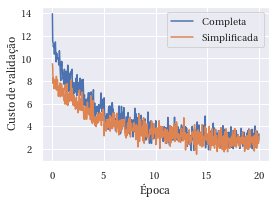

In [19]:
# Landmark: important or not?

for name, var in [('Custo de validação', 'val_loss')]:
    data = {
        'full': results['pytorch'][('VGG16', 'full', 20, 100, 10000)][var],
        'attr': results['pytorch'][('VGG16', 'attr', 100, 100, 10000)][var][:620]
    }
    plt.plot(np.linspace(0, 20, 620), data['full'], label='Completa')
    plt.plot(np.linspace(0, 20, 620), data['attr'], label='Simplificada')
    plt.legend()
    plt.xlabel('Época')
    plt.ylabel(name)
    plt.savefig(str(results_path / f'network_simplification_{var}.pdf'), bbox_inches='tight')
    plt.tight_layout()
    plt.show()


keras
=====
0     0.019967
1     0.020019
2     0.019988
3     0.019975
4     0.019992
5     0.019931
6     0.019995
7     0.020004
8     0.020072
9     0.020180
10    0.020385
11    0.021029
12    0.021536
13    0.022667
14    0.024067
15    0.025107
16    0.026551
17    0.026959
18    0.027337
19    0.027922
Name: val_loss, dtype: float64

pytorch
0      9.525580
1      9.233270
2      7.789906
3      8.266056
4      8.068693
         ...   
615    3.056936
616    2.477162
617    2.473852
618    2.485990
619    3.064214
Name: val_loss, Length: 620, dtype: float64


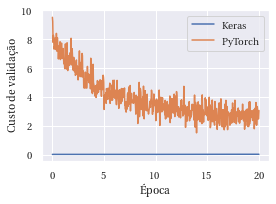

('VGG16', 'attr', 20, 10, 10000): 0.0034509897232055664
('VGG16', 'attr', 20, 100, 10000): 0.0033571720123292126
('VGG16', 'attr', 20, 1000, 10000): 0.0033949613571168102


In [20]:
# Pytorch vs Keras

for name, var in [('Custo de validação', 'val_loss')]:
    data = {
        'keras': results['keras'][('VGG16', 'attr', 20, 100, 10000)][var],
        'pytorch': results['pytorch'][('VGG16', 'attr', 100, 100, 10000)][var][:620]
    }

    for key, value in data.items():
        print_header(key)
        print(value)

    plt.plot(np.linspace(0, 20, 20), data['keras'], label='Keras')
    plt.plot(np.linspace(0, 20, 620), data['pytorch'], label='PyTorch')
    plt.legend()
    plt.xlabel('Época')
    plt.ylabel(name)
    plt.savefig(str(results_path / f'implementation_comparison_{var}.pdf'), bbox_inches='tight')
    plt.tight_layout()
    plt.show()

for w in [10, 100, 1000]:
    key = ('VGG16', 'attr', 20, w, 10000)
    print(f'{key}:', float(results['keras'][key]['val_error_rate'].tail(1)))


pytorch
0       9.525580
1       9.233270
2       7.789906
3       8.266056
4       8.068693
          ...   
3095    3.105020
3096    1.851228
3097    2.332556
3098    2.944676
3099    1.591809
Name: val_loss, Length: 3100, dtype: float64


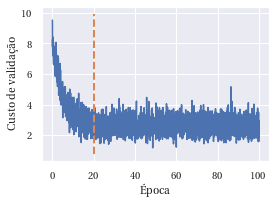

In [21]:
# Training curve

for name, var in [('Custo de validação', 'val_loss')]:
    data = {
        'pytorch': results['pytorch'][('VGG16', 'attr', 100, 100, 10000)][var]
    }

    for key, value in data.items():
        print_header(key)
        print(value)

    mark_epoch = 20

    plt.plot(np.linspace(0, 100, len(data['pytorch'])), data['pytorch'], label='Training Curve')
    plt.plot(2*[mark_epoch], plt.ylim(), '--', linewidth=2)

    plt.xlabel('Época')
    plt.ylabel(name)
    plt.savefig(str(results_path / f'training_curve_{var}.pdf'), bbox_inches='tight')
    plt.tight_layout()
    plt.show()


5000
====
0     0.020420
1     0.020360
2     0.020284
3     0.020226
4     0.020310
5     0.020179
6     0.020248
7     0.020503
8     0.021188
9     0.021647
10    0.023710
11    0.023787
12    0.024735
13    0.025193
14    0.025381
15    0.025352
16    0.025414
17    0.026803
18    0.027557
19    0.027455
20    0.026975
21    0.027257
22    0.029538
23    0.030575
24    0.029623
25    0.029516
26    0.029485
27    0.031425
28    0.032715
29    0.033221
30    0.032972
31    0.032450
32    0.033219
33    0.033753
34    0.034251
35    0.034703
36    0.034874
37    0.035120
38    0.035361
39    0.035532
Name: val_loss, dtype: float64

10000
=====
0     0.020118
1     0.020051
2     0.020038
3     0.020053
4     0.020029
5     0.020115
6     0.020334
7     0.020989
8     0.022011
9     0.023064
10    0.023234
11    0.023440
12    0.024125
13    0.023997
14    0.024083
15    0.024588
16    0.025508
17    0.026062
18    0.025761
19    0.026060
Name: val_loss, dtype: float64

200000
0     

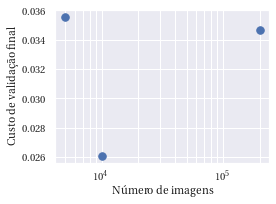


5000
====
0     0.003415
1     0.003415
2     0.003415
3     0.003415
4     0.003415
5     0.003415
6     0.003415
7     0.003415
8     0.003416
9     0.003419
10    0.003430
11    0.003426
12    0.003447
13    0.003442
14    0.003447
15    0.003446
16    0.003444
17    0.003475
18    0.003499
19    0.003492
20    0.003481
21    0.003478
22    0.003546
23    0.003579
24    0.003552
25    0.003544
26    0.003543
27    0.003607
28    0.003647
29    0.003677
30    0.003662
31    0.003638
32    0.003673
33    0.003693
34    0.003710
35    0.003726
36    0.003728
37    0.003739
38    0.003749
39    0.003756
Name: val_error_rate, dtype: float64

10000
=====
0     0.003369
1     0.003369
2     0.003369
3     0.003369
4     0.003369
5     0.003369
6     0.003368
7     0.003371
8     0.003378
9     0.003388
10    0.003379
11    0.003382
12    0.003386
13    0.003386
14    0.003386
15    0.003388
16    0.003393
17    0.003398
18    0.003393
19    0.003395
Name: val_error_rate, dtype: float64

2

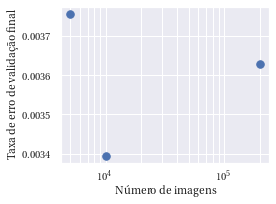

In [22]:
# Learning curve

for name, var in [('Custo de validação', 'val_loss'), ('Taxa de erro de validação', 'val_error_rate')]:
    data = {
        5000: results['keras'][('VGG16', 'attr', 20, 1000, 5000)][var],
        10000: results['keras'][('VGG16', 'attr', 20, 1000, 10000)][var],
        200000: results['keras'][('VGG16', 'attr', 20, 1000, 200000)][var]
    }

    for key, value in data.items():
        print_header(key)
        print(value)

    keys = list(data.keys())

    values = [
        float(value.tail(1))
        for value in data.values()
    ]

    print(keys)
    print(values)

    plt.plot(keys, values, '.', label='Learning Curve', markersize=15)

    plt.xlabel('Número de imagens')
    plt.ylabel(name + ' final')
    plt.xscale('log')
    plt.grid(True, which='minor')
    plt.savefig(str(results_path / f'learning_curve_{var}.pdf'), bbox_inches='tight')
    plt.tight_layout()
    plt.show()


1000
====
0     0.020118
1     0.020051
2     0.020038
3     0.020053
4     0.020029
5     0.020115
6     0.020334
7     0.020989
8     0.022011
9     0.023064
10    0.023234
11    0.023440
12    0.024125
13    0.023997
14    0.024083
15    0.024588
16    0.025508
17    0.026062
18    0.025761
19    0.026060
Name: val_loss, dtype: float64

100
===
0     0.019967
1     0.020019
2     0.019988
3     0.019975
4     0.019992
5     0.019931
6     0.019995
7     0.020004
8     0.020072
9     0.020180
10    0.020385
11    0.021029
12    0.021536
13    0.022667
14    0.024067
15    0.025107
16    0.026551
17    0.026959
18    0.027337
19    0.027922
Name: val_loss, dtype: float64

10
==
0     0.020325
1     0.020280
2     0.020260
3     0.020310
4     0.020309
5     0.020313
6     0.020511
7     0.020779
8     0.021549
9     0.022460
10    0.023071
11    0.023794
12    0.024600
13    0.024409
14    0.023929
15    0.024795
16    0.025257
17    0.026010
Name: val_loss, dtype: float64

1
=
0    

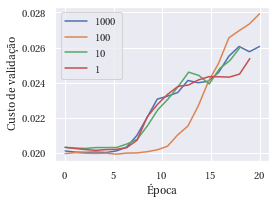


1000
====
0     0.003369
1     0.003369
2     0.003369
3     0.003369
4     0.003369
5     0.003369
6     0.003368
7     0.003371
8     0.003378
9     0.003388
10    0.003379
11    0.003382
12    0.003386
13    0.003386
14    0.003386
15    0.003388
16    0.003393
17    0.003398
18    0.003393
19    0.003395
Name: val_error_rate, dtype: float64

100
===
0     0.003327
1     0.003327
2     0.003327
3     0.003327
4     0.003327
5     0.003327
6     0.003327
7     0.003327
8     0.003327
9     0.003327
10    0.003327
11    0.003327
12    0.003328
13    0.003328
14    0.003339
15    0.003341
16    0.003348
17    0.003348
18    0.003354
19    0.003357
Name: val_error_rate, dtype: float64

10
==
0     0.003419
1     0.003419
2     0.003419
3     0.003419
4     0.003419
5     0.003419
6     0.003420
7     0.003421
8     0.003426
9     0.003431
10    0.003428
11    0.003437
12    0.003445
13    0.003437
14    0.003432
15    0.003436
16    0.003444
17    0.003451
Name: val_error_rate, dtype: 

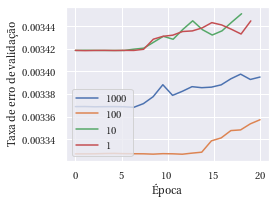

In [23]:
# Weights

for name, var in [('Custo de validação', 'val_loss'), ('Taxa de erro de validação', 'val_error_rate')]:
    data = {
        1000: results['keras'][('VGG16', 'attr', 20, 1000, 10000)][var],
        100: results['keras'][('VGG16', 'attr', 20, 100, 10000)][var],
        10: results['keras'][('VGG16', 'attr', 20, 10, 10000)][var],
        1: results['keras'][('VGG16', 'attr', 20, 1, 10000)][var]
    }

    for key, value in data.items():
        print_header(str(key))
        print(value)

    plt.plot(np.linspace(0, 20, 20), data[1000], label=1000)
    plt.plot(np.linspace(0, 20, 20), data[100], label=100)
    plt.plot(np.linspace(0, 18, 18), data[10], label=10)
    plt.plot(np.linspace(0, 19, 19), data[1], label=1)
    
    loc = 'best'
    if var == 'val_error_rate':
        loc = 'lower left'
    plt.legend(loc=loc)

    plt.xlabel('Época')
    plt.ylabel(name)
    plt.savefig(str(results_path / f'weight_influence_{var}.pdf'), bbox_inches='tight')
    plt.tight_layout()
    plt.show()


VGG16
=====
0     0.019967
1     0.020019
2     0.019988
3     0.019975
4     0.019992
5     0.019931
6     0.019995
7     0.020004
8     0.020072
9     0.020180
10    0.020385
11    0.021029
12    0.021536
13    0.022667
14    0.024067
15    0.025107
16    0.026551
17    0.026959
18    0.027337
19    0.027922
Name: val_loss, dtype: float64

MobileNetV2
0     0.030766
1     0.026110
2     0.023928
3     0.023063
4     0.022350
5     0.022120
6     0.022156
7     0.022128
8     0.022118
9     0.022127
10    0.022192
11    0.022161
12    0.022216
13    0.022231
14    0.022320
15    0.022422
16    0.022475
17    0.022432
18    0.022439
19    0.022664
Name: val_loss, dtype: float64

ResNet50V2
0     0.024927
1     0.020915
2     0.020931
3     0.021296
4     0.021512
5     0.021877
6     0.022164
7     0.021878
8     0.021981
9     0.022015
10    0.022214
11    0.022099
12    0.022315
13    0.022147
14    0.022355
15    0.022258
16    0.022370
Name: val_loss, dtype: float64


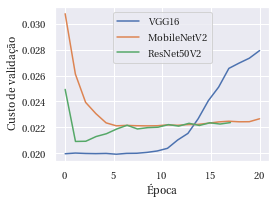


VGG16
=====
0     0.003327
1     0.003327
2     0.003327
3     0.003327
4     0.003327
5     0.003327
6     0.003327
7     0.003327
8     0.003327
9     0.003327
10    0.003327
11    0.003327
12    0.003328
13    0.003328
14    0.003339
15    0.003341
16    0.003348
17    0.003348
18    0.003354
19    0.003357
Name: val_error_rate, dtype: float64

MobileNetV2
0     0.003582
1     0.003539
2     0.003519
3     0.003520
4     0.003512
5     0.003512
6     0.003511
7     0.003510
8     0.003509
9     0.003509
10    0.003511
11    0.003510
12    0.003510
13    0.003510
14    0.003511
15    0.003510
16    0.003509
17    0.003513
18    0.003514
19    0.003514
Name: val_error_rate, dtype: float64

ResNet50V2
0     0.003505
1     0.003479
2     0.003479
3     0.003480
4     0.003484
5     0.003489
6     0.003492
7     0.003484
8     0.003492
9     0.003490
10    0.003490
11    0.003486
12    0.003491
13    0.003485
14    0.003489
15    0.003489
16    0.003485
Name: val_error_rate, dtype: floa

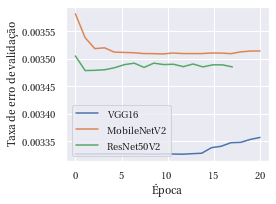

In [24]:
# Architecture

for name, var in [('Custo de validação', 'val_loss'), ('Taxa de erro de validação', 'val_error_rate')]:
    data = {
        'VGG16': results['keras'][('VGG16', 'attr', 20, 100, 10000)][var],
        'MobileNetV2': results['keras'][('MobileNetV2', 'attr', 20, 100, 10000)][var],
        'ResNet50V2': results['keras'][('ResNet50V2', 'attr', 20, 100, 10000)][var]
    }

    for key, value in data.items():
        print_header(key)
        print(value)

    plt.plot(np.linspace(0, 20, 20), data['VGG16'], label='VGG16')
    plt.plot(np.linspace(0, 20, 20), data['MobileNetV2'], label='MobileNetV2')
    plt.plot(np.linspace(0, 17, 17), data['ResNet50V2'], label='ResNet50V2')
    
    loc = 'best'
    if var == 'val_error_rate':
        loc = 'lower left'
    plt.legend(loc=loc)

    plt.xlabel('Época')
    plt.ylabel(name)
    plt.savefig(str(results_path / f'architecture_comparison_{var}.pdf'), bbox_inches='tight')
    plt.tight_layout()
    plt.show()